In [2]:
'''
This script build logsitc regression/ RF/GBT/NN models for the logistic regression model/RF/gradient boosting/Neural Network model
Author: Yue Wen

'''
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

#read the processed data
feature_matrix = pd.read_csv("final_data.csv")
del feature_matrix["Unnamed: 0"]

### prepare feature matrix

In [4]:
# out of 2 standard deviation
feature_matrix["2to3_change_perc"].std() # around 10%
# define decrease/incerease out of two standard deviation as big decrease
feature_matrix["2to3_big_decrease"] =  np.where(feature_matrix["2to3_change_perc"] < -0.2,1,0)
feature_matrix["1to2_big_decrease"] = np.where(feature_matrix["1to2_change_perc"] < -0.2,1,0)

In [6]:
# put the churn to the last column
churn = feature_matrix["churn"]
del feature_matrix["churn"]
feature_matrix["churn"] = churn

feature_matrix.head()

,uid,device,p1_cnt,p2_cnt,p3_cnt,type0_perc,type1_perc,type2_perc,song_type_entropy,period_3_no_behavior,period_23_no_behavior,2to3_change_perc,1to2_change_perc,2to3_big_decrease,1to2_big_decrease,churn
0,168550571.0,1,57,47,0,0.576923,0.423077,0.000000,0.681266,1,0,-1.000000,-0.175439,1,0,1
1,168551392.0,1,106,166,36,1.000000,0.000000,0.000000,-0.000000,0,0,-0.783133,0.566038,1,0,1
2,168550793.0,1,47,0,62,0.601010,0.398990,0.000000,0.672600,0,0,1.000000,-1.000000,0,1,0
3,168547001.0,1,159,84,297,0.998485,0.000000,0.001515,0.011351,0,0,2.535714,-0.471698,0,1,0
4,21940901.0,1,599,777,0,0.998612,0.000000,0.001388,0.010519,1,0,-1.000000,0.297162,1,0,0


In [7]:
feature_matrix.churn.describe()

count    610629.000000
mean          0.675718
std           0.468106
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: churn, dtype: float64

In [8]:
#remove outlier
total_cnt = feature_matrix.apply(lambda x: x.p1_cnt +  x.p2_cnt + x.p3_cnt,1)
total_cnt_sorted = total_cnt.sort_values()

#remove outlier
up_bound = np.percentile(total_cnt,99.5)
outlier = feature_matrix.uid[  (total_cnt>= up_bound)]
feature_matrix = feature_matrix[~feature_matrix.uid.isin(outlier)]

In [11]:
# train, test split 
X = feature_matrix.iloc[:,1:-1].values

y = feature_matrix["churn"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

### Logistic regression

In [28]:
# logistic regreesion
from sklearn.linear_model import LogisticRegression

model_lrc = LogisticRegression(fit_intercept=True)
model_lrc.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [169]:
model_lrc.score(X_train,y_train)

0.82707111304595415

In [170]:
model_lrc.score(X_test,y_test)

0.82633490137822896

In [209]:
y_test_pred_lrc = model_lrc.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_test_pred_lrc)

0.88731341687445009

### Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(max_depth = None, n_estimators = 50, min_samples_leaf = 10,random_state = 0)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [172]:
model_rfc.score(X_train, y_train)

0.85939147353196654

In [173]:
model_rfc.score(X_test, y_test)

0.84114054633985313

In [210]:
y_test_pred_prob = model_rfc.predict_proba(X_test)[:,1]

In [211]:
roc_auc_score(y_test,y_test_pred_prob)

0.90070398386209627

In [25]:
importances =model_rfc.feature_importances_ 
importances = pd.Series(importances, index = list(feature_matrix.columns)[1:-1])
importances = importances.sort_values(ascending = False)

In [26]:
importances

period_3_no_behavior     0.261609
p3_cnt                   0.212732
1to2_change_perc         0.126149
2to3_change_perc         0.099190
p2_cnt                   0.098728
period_23_no_behavior    0.072462
p1_cnt                   0.053572
song_type_entropy        0.020661
type0_perc               0.019587
type1_perc               0.012881
2to3_big_decrease        0.009842
device                   0.005628
type2_perc               0.004912
1to2_big_decrease        0.002047
dtype: float64

### Gradient boosting classifier

In [175]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbt = GradientBoostingClassifier(n_estimators=200, max_depth=5)

model_gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [176]:
model_gbt.score(X_train, y_train)

0.84368623356902195

In [177]:
model_gbt.score(X_test, y_test)

0.84164397128001978

In [208]:
y_test_pred_gbc = model_gbt.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_test_pred_gbc)

0.90078136250657215

### Neural network

In [16]:
import tensorflow as tf

In [181]:
hidden_dim = 100
reg_tf = tf.constant(0.01)
input_dim = 14
learning_rate = 1e-2
epoch_num = 20

x_tf = tf.placeholder(tf.float32, shape=(None, input_dim))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(input_dim, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 2).astype('float32'))
b2_tf = tf.Variable(np.zeros((2,)).astype('float32'))
# xw +b -> relu
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
#matmul:  matrix multiplier 
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,2))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 488503
batch_size = 1000
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(epoch_num):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    y_pred_nn = sess.run(tf.argmax(h2_tf,1),feed_dict={x_tf: X_test, y_tf: y_test})
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7991499304771423
epoch 2: valid acc = 0.8018898963928223
epoch 3: valid acc = 0.8080548048019409
epoch 4: valid acc = 0.8161261081695557
epoch 5: valid acc = 0.8211438655853271
epoch 6: valid acc = 0.8259057402610779
epoch 7: valid acc = 0.8287364840507507
epoch 8: valid acc = 0.8293554782867432
epoch 9: valid acc = 0.8266814947128296
epoch 10: valid acc = 0.8272014260292053
epoch 11: valid acc = 0.8295617699623108
epoch 12: valid acc = 0.8290418386459351
epoch 13: valid acc = 0.8300156593322754
epoch 14: valid acc = 0.8294544816017151
epoch 15: valid acc = 0.8302302360534668
epoch 16: valid acc = 0.8302632570266724
epoch 17: valid acc = 0.8301064372062683
epoch 18: valid acc = 0.8301889896392822
epoch 19: valid acc = 0.8302632570266724
epoch 20: valid acc = 0.8301972150802612
test acc = 0.8301972150802612


In [203]:
hidden_dim = 100
reg_tf = tf.constant(0.01)
input_dim = 14
learning_rate = 1e-2
epoch_num = 20

x_tf = tf.placeholder(tf.float32, shape=(None, input_dim))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(input_dim, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 2).astype('float32'))
b2_tf = tf.Variable(np.zeros((2,)).astype('float32'))
# xw +b -> relu
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
#matmul:  matrix multiplier 
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,2))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 488503
batch_size = 1000
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(epoch_num):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    y_pred_nn = sess.run(tf.argmax(h2_tf,1),feed_dict={x_tf: X_test, y_tf: y_test})
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
    print('test acc = {}'.format(test_acc))
    

epoch 1: valid acc = 0.7991747260093689
epoch 2: valid acc = 0.8015432953834534
epoch 3: valid acc = 0.8082363605499268
epoch 4: valid acc = 0.8158785104751587
epoch 5: valid acc = 0.8214657306671143
epoch 6: valid acc = 0.8263431787490845
epoch 7: valid acc = 0.8293224573135376
epoch 8: valid acc = 0.8284229040145874
epoch 9: valid acc = 0.8261615633964539
epoch 10: valid acc = 0.8272757530212402
epoch 11: valid acc = 0.8286952376365662
epoch 12: valid acc = 0.8296113014221191
epoch 13: valid acc = 0.8302880525588989
epoch 14: valid acc = 0.8297185897827148
epoch 15: valid acc = 0.8299413919448853
epoch 16: valid acc = 0.8299661874771118
epoch 17: valid acc = 0.8304943442344666
epoch 18: valid acc = 0.8307254314422607
epoch 19: valid acc = 0.830717146396637
epoch 20: valid acc = 0.8311710953712463
test acc = 0.8311710953712463


## Pick the best model and examine other metrics

In [182]:
from  sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [28]:
def print_results(y_test, y_pred):
    print("Accuracy of the model is {}".format(accuracy_score(y_test,y_test_pred)))
    print("Precision of the model is {}".format(precision_score(y_test,y_test_pred)))
    print("Recall of the model is {}".format(recall_score(y_test,y_test_pred)))
    print("f1-score of the model is {}".format(f1_score(y_test,y_test_pred)))


Random Forest scores on test set:
Accuracy of the model is 0.8411405463398531
Precision of the model is 0.872367536190847
Recall of the model is 0.8976472587772544
f1-score of the model is 0.8848268723336783



### confusion matrix

[[27980 10818]
 [ 8431 73941]]


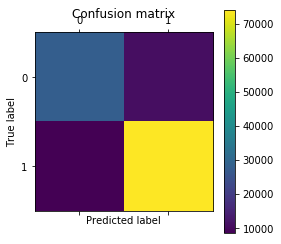

In [187]:
# plot the confusion matrix for ranfom forest modeel
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve
def plot_confusion_matrix(y_true,y_pred):
    '''
    Plot confusion matrix given the true/predicted value 
    '''
    
    cm = confusion_matrix(y_true,y_pred)
    
    print(cm)
    
    plt.matshow(cm)
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

plot_confusion_matrix(y_test,  y_test_pred)

### AUC

In [215]:
print("Area under Curve of the random forest model is {}".format(roc_auc_score(y_test,y_test_pred_prob)))

Area under Curve of the random forest model is 0.9007039838620963


In [189]:
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

          0       0.77      0.72      0.74     38798
          1       0.87      0.90      0.88     82372

avg / total       0.84      0.84      0.84    121170



### optimize through thredsholds

In [194]:
y_test_pred_prob  =  model_rfc.predict_proba(X_test)[:,1]
# check the optimal threshold 
thresholds =  [ 0.1*i for i in range(9)]
# calculate the corresponding accuracy given thredshold
accuracy = []
for threshold in thresholds:
    y_dummy_pred = np.array(y_test_pred_prob>threshold).astype(int)
    accuracy.append(np.mean(y_dummy_pred == y_test))

thresholds =  [ 0.4 + 0.01*i for i in range(20)]
accuracy = []
for threshold in thresholds:
    print("when threshold is",threshold)
    y_dummy_pred = np.array(y_test_pred_prob>threshold).astype(int)
    accuracy.append(np.mean(y_dummy_pred == y_test))
    print("the accuracy rate is",np.mean(y_dummy_pred == y_test))

when threshold is 0.4
the accuracy rate is 0.834695056532
when threshold is 0.41000000000000003
the accuracy rate is 0.83586696377
when threshold is 0.42000000000000004
the accuracy rate is 0.836898572254
when threshold is 0.43000000000000005
the accuracy rate is 0.837880663531
when threshold is 0.44
the accuracy rate is 0.838738961789
when threshold is 0.45
the accuracy rate is 0.8390443179
when threshold is 0.46
the accuracy rate is 0.839630271519
when threshold is 0.47000000000000003
the accuracy rate is 0.839952133366
when threshold is 0.48000000000000004
the accuracy rate is 0.840463811174
when threshold is 0.49
the accuracy rate is 0.841132293472
when threshold is 0.5
the accuracy rate is 0.84114054634
when threshold is 0.51
the accuracy rate is 0.841214822151
when threshold is 0.52
the accuracy rate is 0.840958983247
when threshold is 0.53
the accuracy rate is 0.840967236115
when threshold is 0.54
the accuracy rate is 0.840711397211
when threshold is 0.55
the accuracy rate is 0.

### Plot ROC curve


In [195]:
fpr, tpr,  thresholds = roc_curve(y_test,y_test_pred_prob)

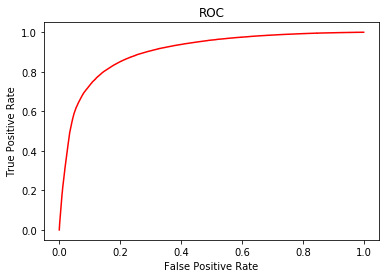

In [196]:
plt.plot(fpr, tpr, color = "red")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()